# **K-means Clustering**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer


In [2]:
casino = pd.read_csv('data/Online_casino_DIB.csv')
casino['ReqTimeUTC'] = pd.to_datetime(casino['ReqTimeUTC'])

casino = casino[casino['ReqTimeUTC'] < '2020-02-29 00:00:00+00:00'].copy()
casino['TransactionType'] = casino['TransactionType'].map({'LOYALTYCARDDEBIT':'L2D', 'LOYALTYCARDCREDITCL':'L1D', 'LOYALTYCARDCREDIT':'L2W'})
casino = casino[(casino['TransactionType'] == 'L2D') & (casino['Status'] == 'APPROVED')].reset_index(drop=True)
casino = casino[['AccountIdentifier', 'ReqTimeUTC', 'TransactionAmount']]
casino = casino.sort_values(['AccountIdentifier', 'ReqTimeUTC']).reset_index(drop=True)
casino.rename(columns={'AccountIdentifier': 'customer', 'ReqTimeUTC': 'timest', 'TransactionAmount':'amount'}, inplace=True)
casino

,customer,timest,amount
0,customer1,2019-03-01 17:24:43+00:00,30.0
1,customer1,2019-03-01 19:54:04+00:00,50.0
2,customer1,2019-03-01 22:44:15+00:00,40.0
3,customer1,2019-03-02 02:44:20+00:00,100.0
4,customer1,2019-03-02 18:28:39+00:00,25.0
...,...,...,...
69729,customer997,2019-09-22 00:56:47+00:00,50.0
69730,customer998,2019-11-09 07:03:51+00:00,25.0
69731,customer998,2019-11-09 07:05:05+00:00,25.0
69732,customer999,2019-03-20 10:58:04+00:00,250.0


In [3]:
print(len(casino))
print(len(casino['customer'].unique()))

69734
2280


## Cluster Analysis

**Task**: Based on the features of the customers, create GROUPS such that

- Similar customers are close together: Within-Group variability is small

- Different Customers are far apart: Between-Group variability is large

**Input**: Customer Features

**Output**: One label for each customer, mapping to the group it was assign to. but we don't have any customer featueres so let's build then the process is called 

### FEATURE ENGINEERING

In [4]:
base_timestamp = pd.to_datetime('2020-03-01 00:00:00+00:00')

retention_ = casino.groupby('customer').agg(
    first_active_in_days = ('timest', lambda x:(base_timestamp - x.dt.floor('d').min()).days),
    last_active_in_days = ('timest', lambda x:(base_timestamp - x.dt.floor('d').max()).days),
    nr_purchases = ('timest', 'count')
).reset_index()
retention_

,customer,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,366,2,444
1,customer10,364,2,1130
2,customer100,267,4,56
3,customer1000,300,300,2
4,customer1001,225,21,23
...,...,...,...,...
2275,customer995,304,2,6
2276,customer996,353,170,3
2277,customer997,161,161,1
2278,customer998,113,113,2


- **How much a customer spent since firstly active ?**
- **How much different are the amounts the customer spent ?**

In [5]:
overall_spent = casino.groupby('customer').agg({'amount': ['sum', 'std']}).reset_index()
overall_spent.columns = overall_spent.columns.droplevel(0)
overall_spent.rename(columns={"":'customer'}, inplace=True)
overall_spent

,customer,sum,std
0,customer1,34010.0,37.678533
1,customer10,32089.0,13.940103
2,customer100,1639.0,9.195831
3,customer1000,200.0,0.000000
4,customer1001,689.0,13.769130
...,...,...,...
2275,customer995,348.5,19.800042
2276,customer996,50.0,7.637626
2277,customer997,50.0,NaN
2278,customer998,50.0,0.000000


### **How much does the user spend on average every month**

In [6]:
casino['y_month'] = casino.timest.dt.to_period('M')
monthly_expenditure = casino.groupby(['customer', 'y_month'])['amount'].sum().reset_index()
monthly_average_spend = monthly_expenditure.groupby('customer')['amount'].mean().reset_index()
monthly_average_spend.rename(columns={'amount': 'm_avg_spent'}, inplace=True)
monthly_average_spend

C:\Users\ikiga\AppData\Local\Temp\ipykernel_1920\4219523826.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  casino['y_month'] = casino.timest.dt.to_period('M')


,customer,m_avg_spent
0,customer1,2834.166667
1,customer10,2674.083333
2,customer100,273.166667
3,customer1000,200.000000
4,customer1001,98.428571
...,...,...
2275,customer995,69.700000
2276,customer996,25.000000
2277,customer997,50.000000
2278,customer998,50.000000


In [7]:
overall_spent = overall_spent.set_index('customer')
monthly_average_spend = monthly_average_spend.set_index('customer')
retention_ = retention_.set_index('customer')
customer_data = overall_spent.join([monthly_average_spend, retention_]).reset_index()
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,34010.0,37.678533,2834.166667,366,2,444
1,customer10,32089.0,13.940103,2674.083333,364,2,1130
2,customer100,1639.0,9.195831,273.166667,267,4,56
3,customer1000,200.0,0.000000,200.000000,300,300,2
4,customer1001,689.0,13.769130,98.428571,225,21,23
...,...,...,...,...,...,...,...
2275,customer995,348.5,19.800042,69.700000,304,2,6
2276,customer996,50.0,7.637626,25.000000,353,170,3
2277,customer997,50.0,NaN,50.000000,161,161,1
2278,customer998,50.0,0.000000,50.000000,113,113,2


In [8]:
customer_data.isna().sum()
customer_data.loc[customer_data['std'].isna(), 'std'] = 0.001
customer_data.loc[customer_data["std"] == 0] = 0.001
customer_data

C:\Users\ikiga\AppData\Local\Temp\ipykernel_1920\1950148479.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  customer_data.loc[customer_data["std"] == 0] = 0.001
C:\Users\ikiga\AppData\Local\Temp\ipykernel_1920\1950148479.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  customer_data.loc[customer_data["std"] == 0] = 0.001
C:\Users\ikiga\AppData\Local\Temp\ipykernel_1920\1950148479.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  customer_data.loc[cus

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,34010.000,37.678533,2834.166667,366.000,2.000,444.000
1,customer10,32089.000,13.940103,2674.083333,364.000,2.000,1130.000
2,customer100,1639.000,9.195831,273.166667,267.000,4.000,56.000
3,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001
4,customer1001,689.000,13.769130,98.428571,225.000,21.000,23.000
...,...,...,...,...,...,...,...
2275,customer995,348.500,19.800042,69.700000,304.000,2.000,6.000
2276,customer996,50.000,7.637626,25.000000,353.000,170.000,3.000
2277,customer997,50.000,0.001000,50.000000,161.000,161.000,1.000
2278,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001


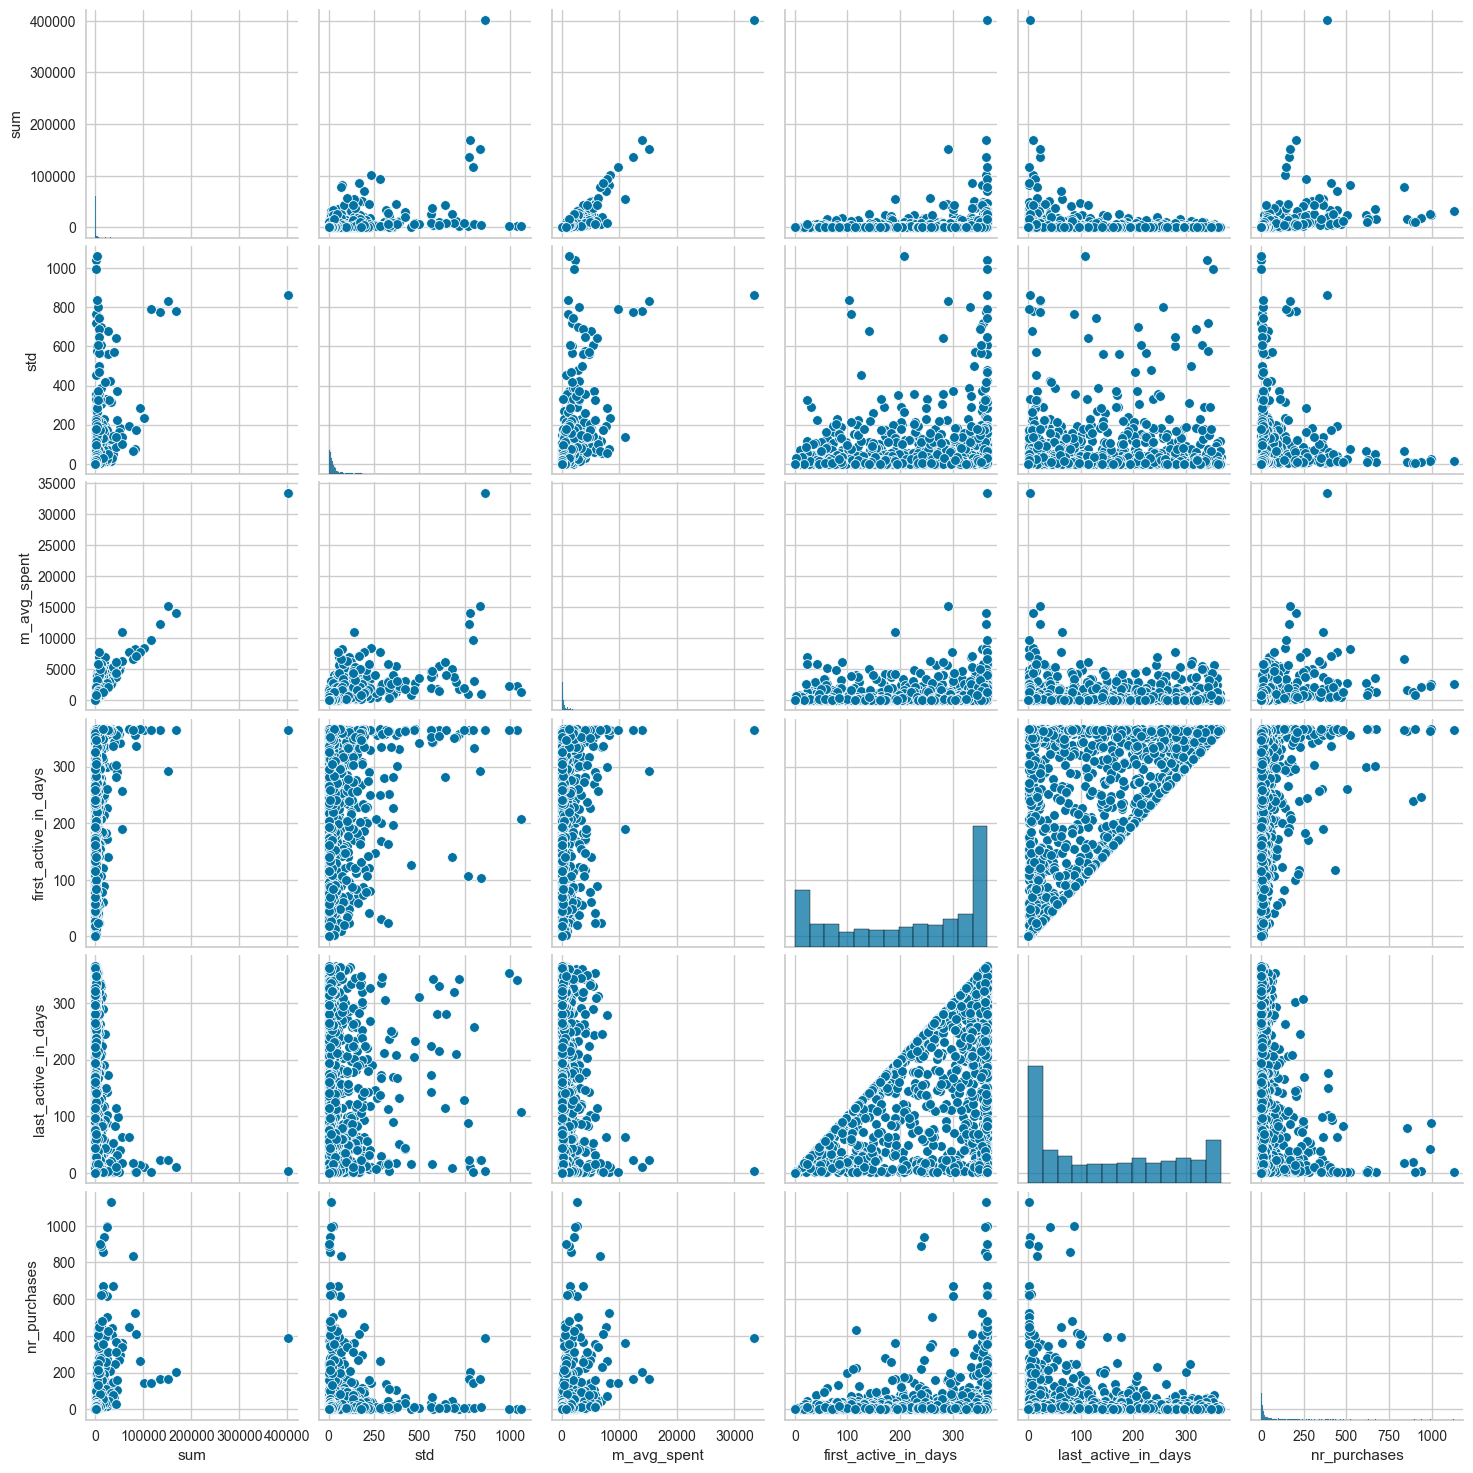

In [9]:
sns.pairplot(customer_data)

In [10]:
X = customer_data[['sum', 'std', 'm_avg_spent', 'first_active_in_days', 'last_active_in_days', 'nr_purchases']]

X_STD = np.log(X)

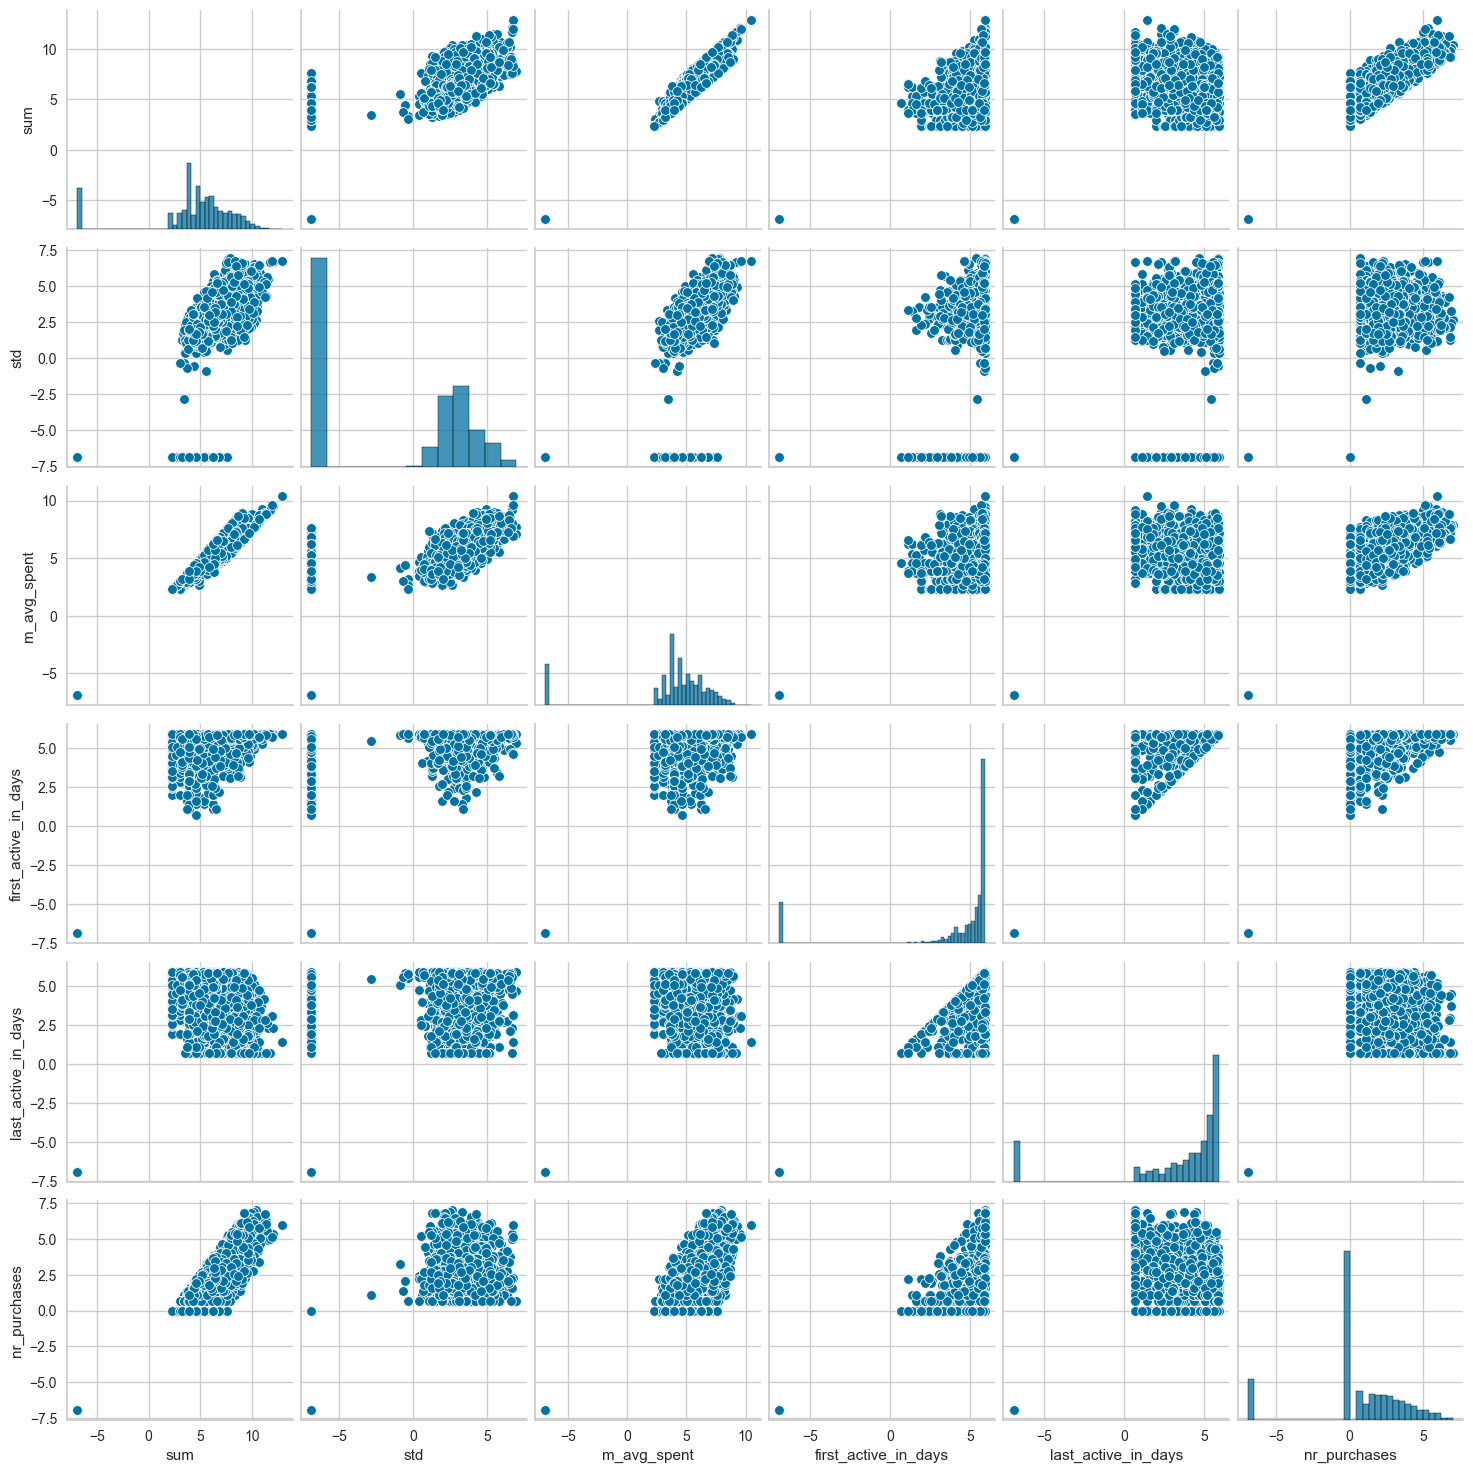

In [11]:
sns.pairplot(X_STD)

In [12]:
wcss_ls = []
for i in range(1,6 + 1):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    wcss = kmeans.inertia_
    wcss_ls.append(wcss)

wcss_ls

[351145738954.5723,
 155838029825.9523,
 95984125299.13777,
 32115691613.23242,
 19727474382.995815,
 11957741793.717852]

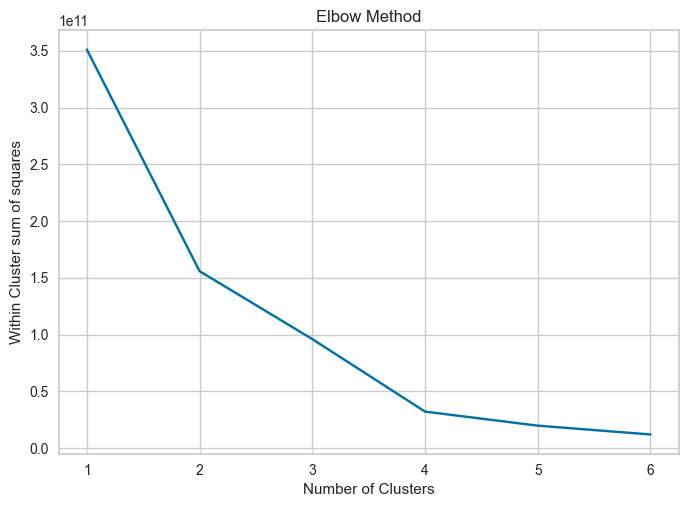

In [13]:
plt.plot(range(1,6 + 1), wcss_ls)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster sum of squares')
plt.show()


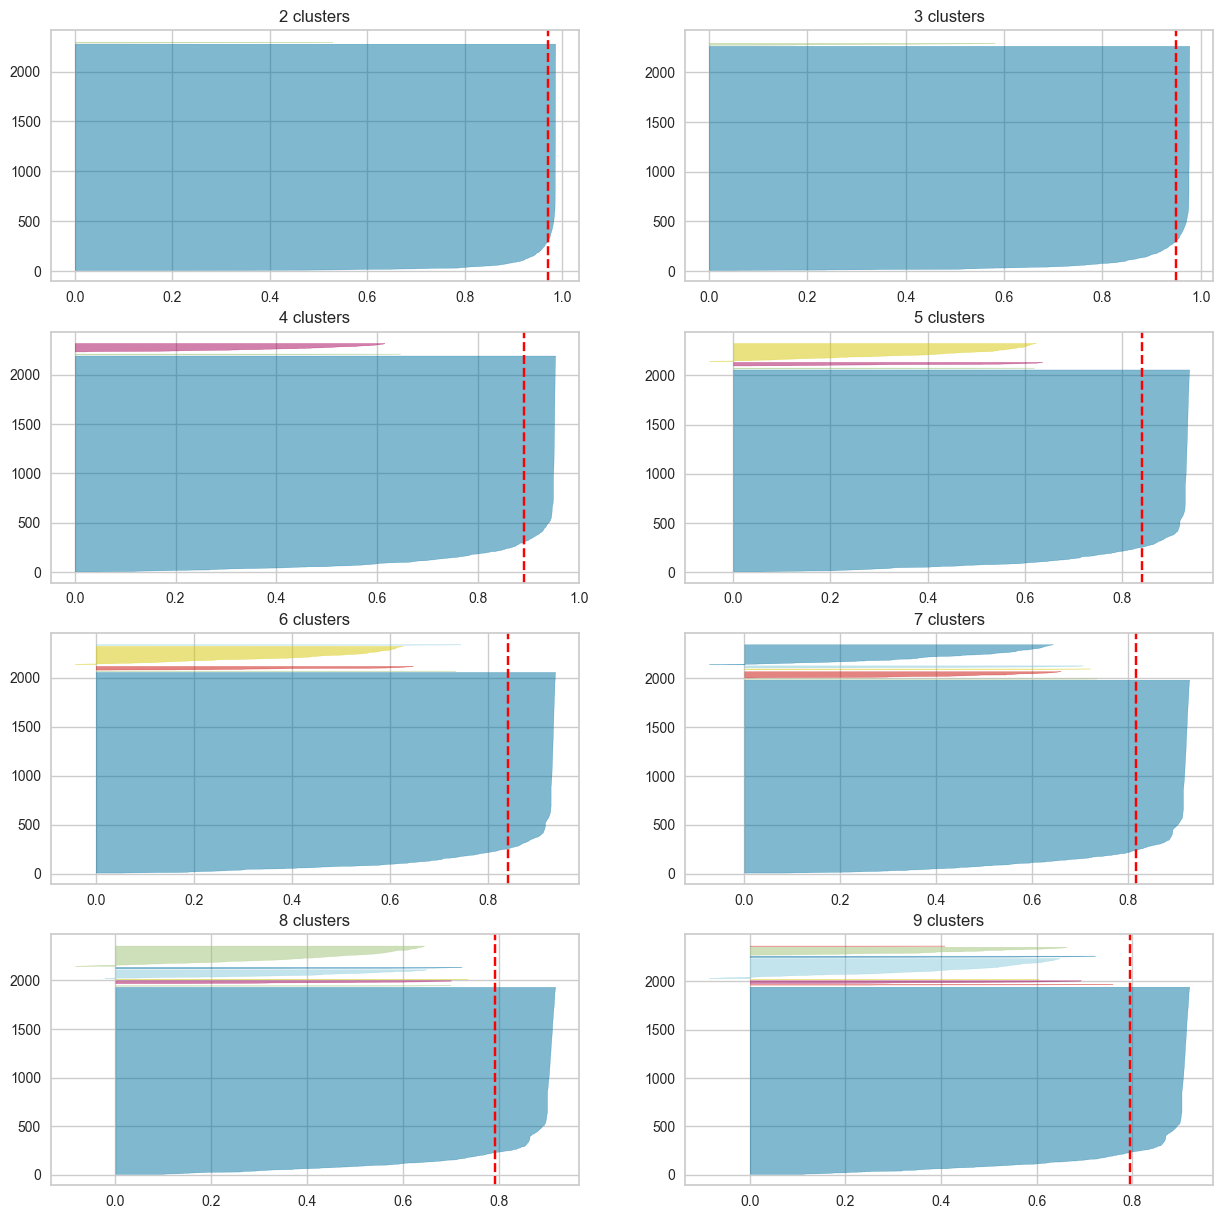

In [14]:
fig, ax = plt.subplots(4,2,figsize=(15,15))

for i in [2,3,4,5,6,7,8,9]:
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=100,random_state=42)
    q, mod = divmod(i,2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    ax[q-1][mod].set_title(f'{i} clusters')


In [15]:
wcss_ls = []
for i in range(1,6 + 1):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_STD)
    wcss = kmeans.inertia_
    wcss_ls.append(wcss)

wcss_ls


[208369.09872861882,
 112844.07351640199,
 18815.59244941576,
 12416.168717219818,
 10698.831819079134,
 9723.715998178293]

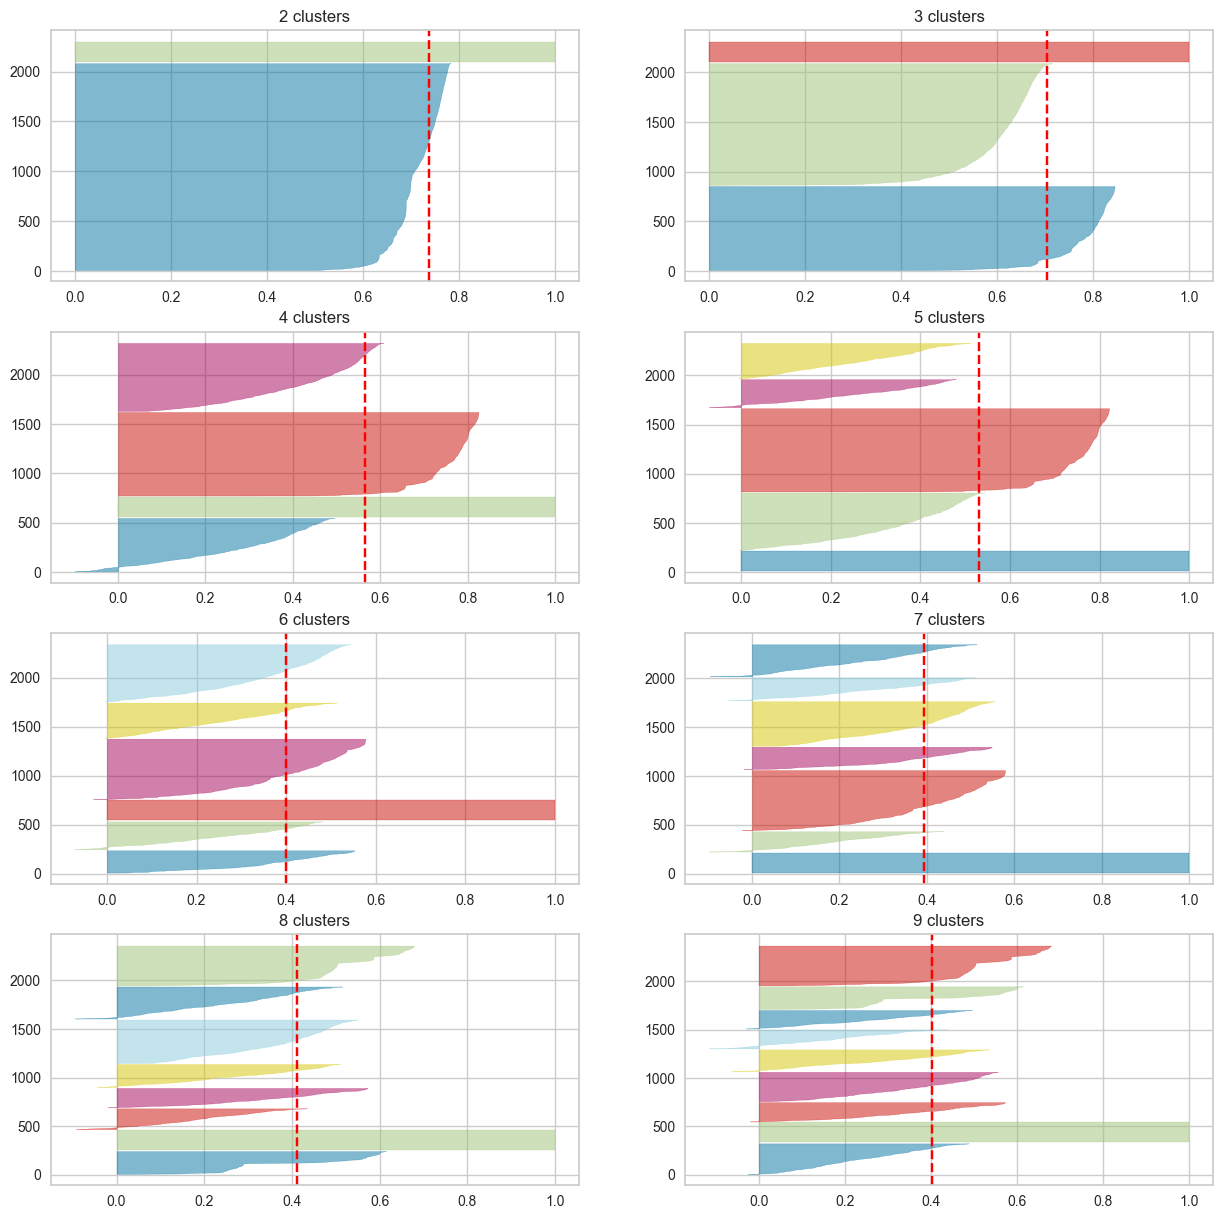

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for i in [2, 3, 4, 5, 6,7,8,9]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_STD)
    ax[q-1][mod].set_title(f"{i} clusters")

In [17]:
cluster_model = KMeans(n_clusters=3)
kmeans = cluster_model.fit(X_STD)
silhouette_score(X_STD, labels = kmeans.labels_)

0.7044985731905409

In [18]:
customer_data['group'] = kmeans.labels_
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases,group
0,customer1,34010.000,37.678533,2834.166667,366.000,2.000,444.000,0
1,customer10,32089.000,13.940103,2674.083333,364.000,2.000,1130.000,0
2,customer100,1639.000,9.195831,273.166667,267.000,4.000,56.000,0
3,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001,1
4,customer1001,689.000,13.769130,98.428571,225.000,21.000,23.000,0
...,...,...,...,...,...,...,...,...
2275,customer995,348.500,19.800042,69.700000,304.000,2.000,6.000,0
2276,customer996,50.000,7.637626,25.000000,353.000,170.000,3.000,0
2277,customer997,50.000,0.001000,50.000000,161.000,161.000,1.000,2
2278,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001,1


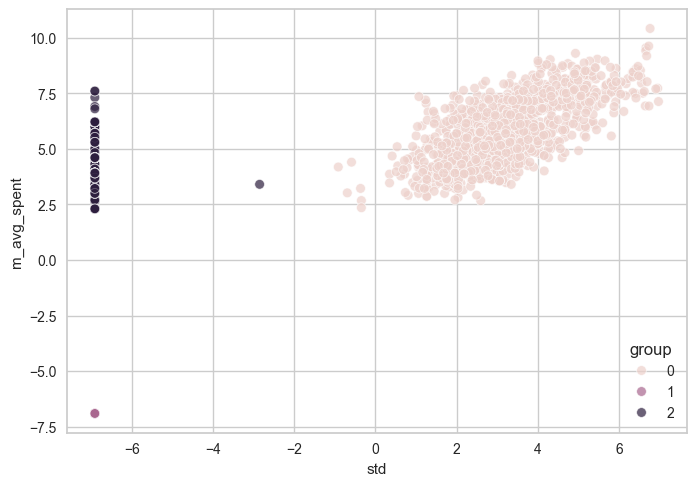

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(X_STD, x = "std", y = "m_avg_spent", hue=customer_data['group'], alpha=0.7)
plt.show()

[0, 7, 54, 403, 2980, 22026, 162754]
[0, 0.02, 0.14, 1.0, 7.39, 54.6, 403.43]


C:\Users\ikiga\AppData\Local\Temp\ipykernel_1920\825431414.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x)
C:\Users\ikiga\AppData\Local\Temp\ipykernel_1920\825431414.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y)


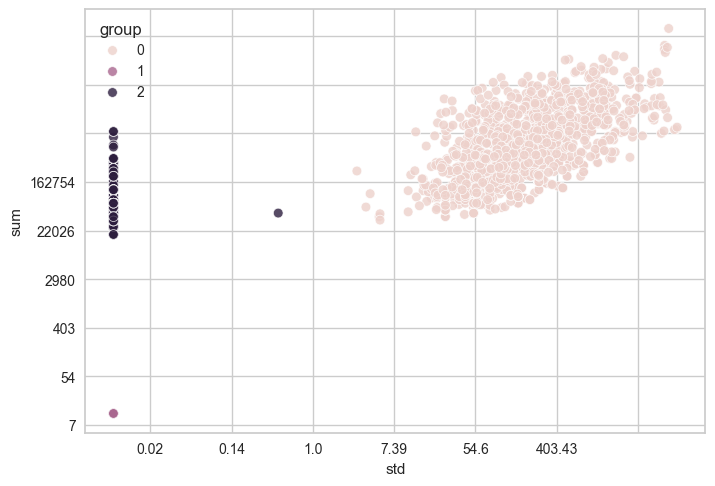

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(X_STD, x = "std", y = "sum", hue=customer_data['group'], alpha=0.8)
# sns.scatterplot(X_std, x = "last_active_in_days", y = "m_avg_spent", hue=customer_data['group'], alpha=0.7)

y = [0]
for i in np.arange(2,14,2):
    nr_int = int(np.exp(i))
    y.append(nr_int)
print(y)

x = [0]
for i in range(-4,7,2):
    nr_int = round(np.exp(i),2)
    x.append(nr_int)
print(x)
ax.set_xticklabels(x)
ax.set_yticklabels(y)
plt.show()